In [1]:
## IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')


In [3]:
# 1. Open datasets
ds_anom = xr.open_dataset('../data/ocean_data_sst/processed/sst_anomaly_daily_1982_2024.nc')
ds_anom['lon'] = ds_anom['lon'] - 360

upwelling_mask_pesca_invierno_da = xr.open_dataset("../data/ocean_data_sst/processed/upwelling_mask_pesca_invierno.nc")
upwelling_mask_pesca_verano_da = xr.open_dataset("../data/ocean_data_sst/processed/upwelling_mask_pesca_verano.nc")

df_prod = pd.read_csv('../data/imarpe/processed/df_tons_by_group.csv').rename({'date': 'time'}, axis=1)
df_prod['time'] = pd.to_datetime(df_prod['time'])
ds_prod = df_prod.set_index('time').to_xarray()
ds_prod = ds_prod.broadcast_like(ds_anom)

# 2. Merge and correlate
ds_final = xr.merge([ds_anom, ds_prod])
ds_summary = ds_final.mean(dim='time')
for group in range(1, 7):
    ds_summary[f'corr_sst_group{group}'] = xr.corr(ds_final[f'Group {group}'], ds_final['sst'], dim='time')

# 3. Function for seasonal correlation
def smooth_and_correlate_by_season(ds, months, window=5):
    ds_season = ds.where(ds.time.dt.month.isin(months), drop=True)
    vars_to_smooth = ['sst'] + [f'Group {i}' for i in range(1, 7)]
    ds_season_smoothed = ds_season[vars_to_smooth].rolling(time=window, center=True).mean()
    ds_summary_season = ds_season_smoothed.mean(dim='time')
    for group in range(1, 7):
        ds_summary_season[f'corr_sst_group{group}'] = xr.corr(ds_season_smoothed[f'Group {group}'], ds_season_smoothed['sst'], dim='time')
    return ds_summary_season

# 4. Seasonal applications
ds_summary_apr_jul_smoothed = smooth_and_correlate_by_season(ds_final, [4, 5, 6, 7])
ds_summary_oct_ene_smoothed = smooth_and_correlate_by_season(ds_final, [11, 12, 1])

In [3]:
# Open geometry datasets
file_path_puertos = '../data/puertos/processed/ports_with_normal_angles_corrected.csv'

df_ports = pd.read_csv(file_path_puertos, index_col=False)

port_groups_dict = {'Group 1': ['CALETA_TORTUGA_(PAITA)', 'CALETA_PARACHIQUE'],
 'Group 2': ['PUERTO_CHIMBOTE', 'PUERTO_SAMANCO'],
 'Group 3': ['PUERTO_HUARMEY',
  'PUERTO_SUPE',
  'DPA_HUACHO_-_FONDEPES',
  'PUERTO_CHANCAY',
  'DPA_CALLAO'],
 'Group 4': ['PUERTO_TAMBO_DE_MORA',
  'TERMINAL_MARINO_PISCO-CAMISEA_(PLUSPETRO)'],
 'Group 5': ['CALETA_ATICO', 'CALETA_PLANCHADA'],
 'Group 6': ['DPA_ILO']}

port_list_original_name = [ 
    'CALETA_TORTUGA_(PAITA)', 'CALETA_PARACHIQUE', 'PUERTO_CHIMBOTE',  
    'PUERTO_SAMANCO',  'PUERTO_HUARMEY', 'PUERTO_SUPE', 
    'DPA_HUACHO_-_FONDEPES','PUERTO_CHANCAY', 'DPA_CALLAO', 
    'PUERTO_TAMBO_DE_MORA', 'TERMINAL_MARINO_PISCO-CAMISEA_(PLUSPETRO)',
    'CALETA_ATICO', 'CALETA_PLANCHADA', 'DPA_ILO'
]

port_list_full_name = [
    'Caleta  tortuga (Paita)',
    'Caleta Parachique',
    'Puerto Chimbote',
    'Puerto Samanco',
    'Puerto Huarmey',
    'Puerto Supe',
    'DPA Huacho - FONDEPES',
    'Puerto Chancay',
    'DPA Callao',
    'Puerto Tambo de Mora',
    'Terminal Marino Pisco-Camisea (Pluspetro)',
    'Caleta Atico',
    'Caleta Planchada',
    'DPA Ilo'
]
port_groups_full = {}
for group, orig_ports in port_groups_dict.items():
    mapped_ports = []
    for port in orig_ports:
        if port in port_list_original_name:
            idx = port_list_original_name.index(port)
            mapped_ports.append(port_list_full_name[idx])
    port_groups_full[group] = mapped_ports



# Plot correlations

In [4]:
group_colors = {
    'Group 1': 'red',
    'Group 2': 'green',
    'Group 3': 'blue',
    'Group 4': 'orange',
    'Group 5': 'purple',
    'Group 6': 'cyan'
}


lon = ds_summary['lon']
lat = ds_summary['lat']
lon_min, lon_max = np.round(lon.min().values * 2) / 2, np.round(lon.max().values * 2) / 2
lat_min, lat_max = np.round(lat.min().values * 2) / 2, np.round(lat.max().values * 2) / 2
lon_ticks = np.linspace(lon_min, lon_max, num=min(5, int((lon_max - lon_min) / 0.5) + 1))
lat_ticks = np.linspace(lat_min, lat_max, num=min(5, int((lat_max - lat_min) / 0.5) + 1))



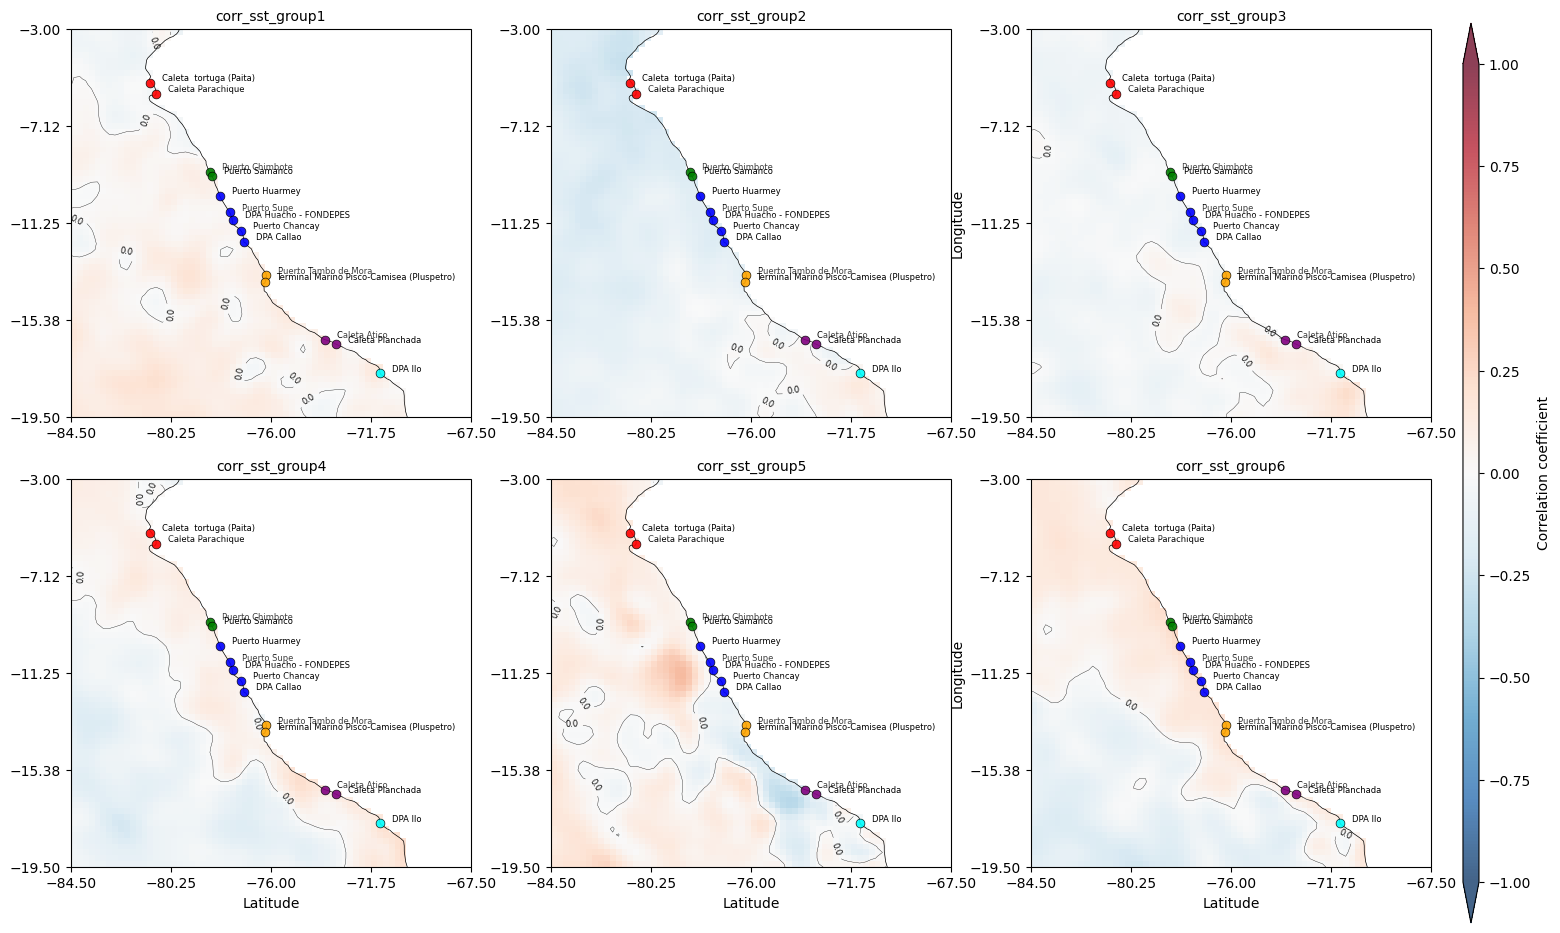

In [5]:

fig = plt.figure(figsize=(16,10))

axes_loc = [
    [0.70, 0.55, 0.25, 0.4],  # Arriba derecha (1er gráfico)
    [0.40, 0.55, 0.25, 0.4],  # Arriba centro
    [0.10, 0.55, 0.25, 0.4],  # Arriba izquierda
    [0.70, 0.10, 0.25, 0.4],  # Abajo derecha
    [0.40, 0.10, 0.25, 0.4],  # Abajo centro
    [0.10, 0.10, 0.25, 0.4]   # Abajo izquierda
]

axes = []


vars=['corr_sst_group3', 'corr_sst_group2', 'corr_sst_group1', 'corr_sst_group6', 'corr_sst_group5', 'corr_sst_group4']
vars=['corr_sst_group3', 'corr_sst_group2', 'corr_sst_group1', 'corr_sst_group6', 'corr_sst_group5', 'corr_sst_group4']


for i, v in enumerate(vars):
    ax = axes_loc[i]
    
    data = ds_summary[v]

    ax = plt.axes(ax, projection=ccrs.PlateCarree())
    axes.append(ax)

    lon2d, lat2d = np.meshgrid(lon, lat)  # Create 2D coordinate grids

    im = ax.pcolormesh(lon2d, lat2d, data.T, cmap='RdBu_r', vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha=0.75)
    levels = np.arange(np.floor(-1), np.ceil(1) + 0.5, 0.5)

    contours = ax.contour(lon2d, lat2d, data.T, levels=levels, colors='k', linewidths=0.25, transform=ccrs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=6, fmt="%.1f")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_title(f"{v}", fontsize=10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())

    # Plot port locations by group
    for group, port_names in port_groups_full.items():
        df_group = df_ports[df_ports['caleta'].isin(port_names)]
        if not df_group.empty:
            ax.scatter(df_group['lon_decimal_corrected'], df_group['lat_decimal_corrected'],
                       color=group_colors[group], edgecolor='black', s=40, alpha=0.9, linewidths=0.5,
                       transform=ccrs.PlateCarree(), zorder=40)
            for _, row in df_group.iterrows():
                ax.text(row['lon_decimal_corrected']+0.5, row['lat_decimal_corrected'], row['caleta'],
                        fontsize=6, color='black', transform=ccrs.PlateCarree(),
                        ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))
    

    if i%3==0:
        ax.set_ylabel('Longitude')
    if i>=3:
        ax.set_xlabel('Latitude')


ax_cbar = plt.axes([0.97, 0.05, 0.01, 0.9])
cbar = fig.colorbar(im, cax=ax_cbar, orientation="vertical", extend='both')
cbar.set_label("Correlation coefficient")
fig.savefig('../docs/figs/oisstv2/corr_sst_produccion.png', dpi=300, bbox_inches='tight')
fig.savefig('../docs/figs/oisstv2/corr_sst_produccion.pdf', bbox_inches='tight')
#plt.close()
    

# correlations winter

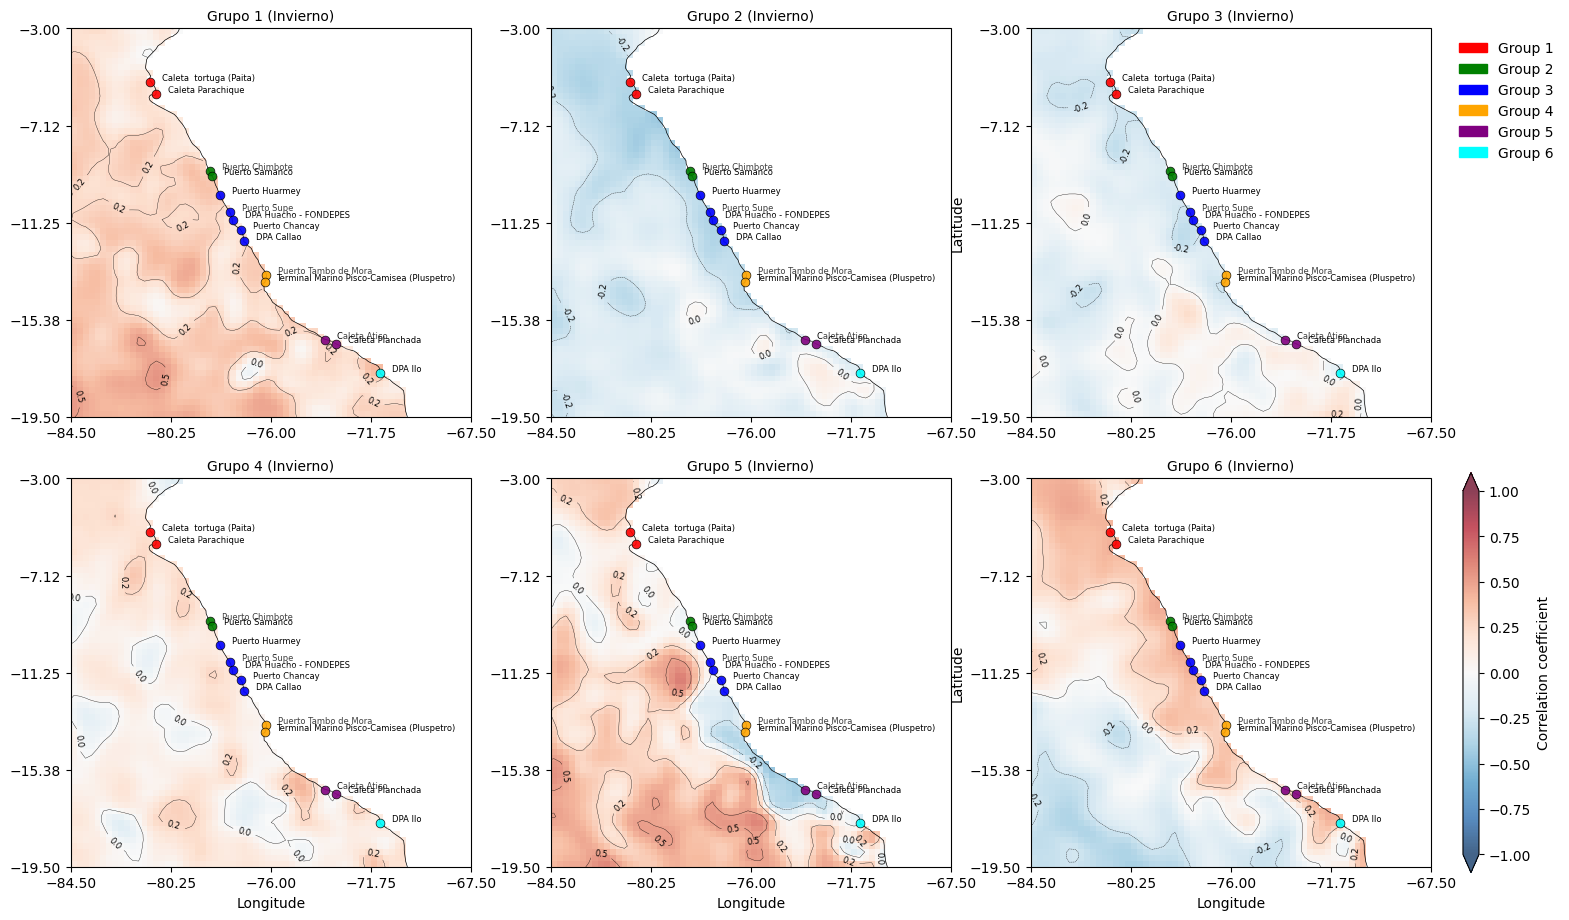

In [6]:

fig = plt.figure(figsize=(16,10))
axes_loc = [
    [0.70, 0.55, 0.25, 0.4],
    [0.40, 0.55, 0.25, 0.4],
    [0.10, 0.55, 0.25, 0.4],
    [0.70, 0.10, 0.25, 0.4],
    [0.40, 0.10, 0.25, 0.4],
    [0.10, 0.10, 0.25, 0.4]
]
axes = []
vars_plot = ['corr_sst_group3', 'corr_sst_group2', 'corr_sst_group1', 
             'corr_sst_group6', 'corr_sst_group5', 'corr_sst_group4']
title_vars_plot = ['Grupo 3', 'Grupo 2', 'Grupo 1', 
                   'Grupo 6', 'Grupo 5', 'Grupo 4']

for i, v in enumerate(vars_plot):
    ax_loc = axes_loc[i]
    data = ds_summary_apr_jul_smoothed[v]
    ax = plt.axes(ax_loc, projection=ccrs.PlateCarree())
    axes.append(ax)
    lon2d, lat2d = np.meshgrid(lon, lat)
    im = ax.pcolormesh(lon2d, lat2d, data.T, cmap='RdBu_r', vmin=-1, vmax=1,
                       transform=ccrs.PlateCarree(), alpha=0.75, shading='auto')
    levels = np.arange(np.floor(-1), np.ceil(1)+0.5, 0.25)
    contours = ax.contour(lon2d, lat2d, data.T, levels=levels, colors='k', linewidths=0.25,
                          transform=ccrs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=6, fmt="%.1f")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_title(f"{title_vars_plot[i]} (Invierno)", fontsize=10)
    
    # Plot port locations by group
    for group, port_names in port_groups_full.items():
        df_group = df_ports[df_ports['caleta'].isin(port_names)]
        if not df_group.empty:
            ax.scatter(df_group['lon_decimal_corrected'], df_group['lat_decimal_corrected'],
                       color=group_colors[group], edgecolor='black', s=40, alpha=0.9, linewidths=0.5,
                       transform=ccrs.PlateCarree(), zorder=40)
            for _, row in df_group.iterrows():
                ax.text(row['lon_decimal_corrected']+0.5, row['lat_decimal_corrected'], row['caleta'],
                        fontsize=6, color='black', transform=ccrs.PlateCarree(),
                        ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))
    
    if i % 3 == 0:
        ax.set_ylabel('Latitude')
    if i >= 3:
        ax.set_xlabel('Longitude')

ax_cbar = plt.axes([0.97, 0.1, 0.01, 0.4])
cbar = fig.colorbar(im, cax=ax_cbar, orientation="vertical", extend='both')
cbar.set_label("Correlation coefficient")

# Create a figure-level legend for port groups
import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=group_colors[group], label=group) for group in group_colors]
fig.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0.96, 0.8), frameon=False)

plt.show()


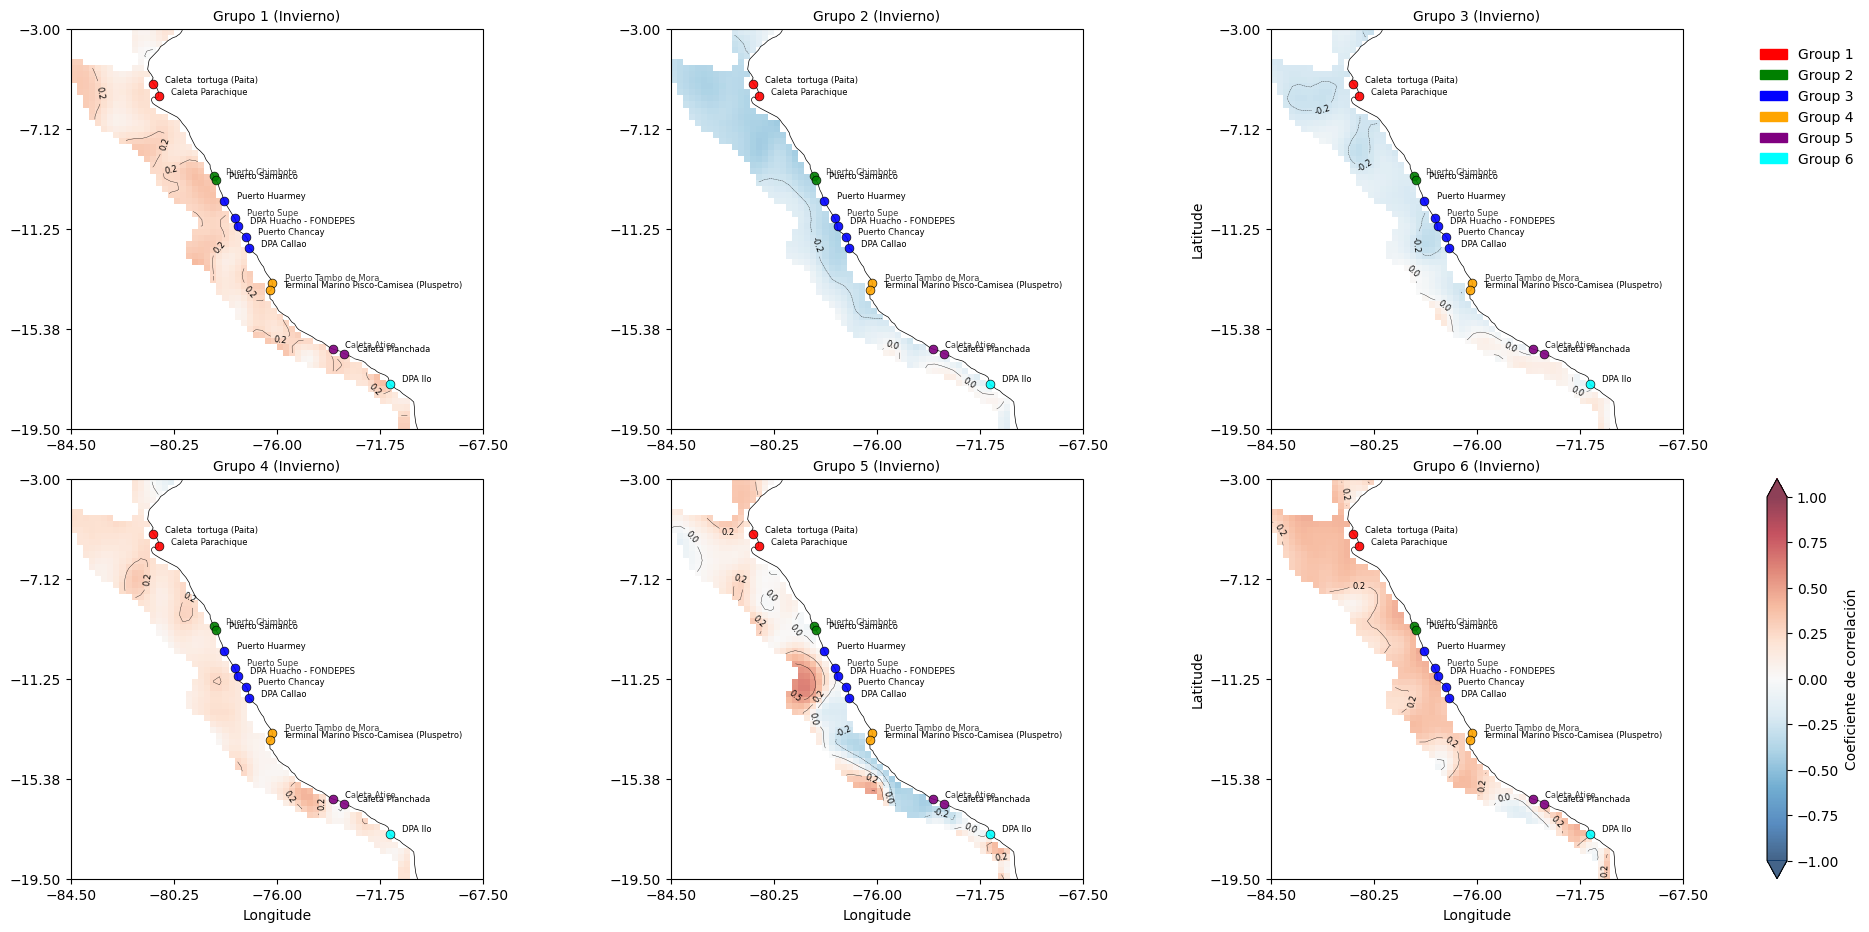

In [7]:

fig = plt.figure(figsize=(20,10))
axes_loc = [
    [0.70, 0.55, 0.25, 0.4],
    [0.40, 0.55, 0.25, 0.4],
    [0.10, 0.55, 0.25, 0.4],
    [0.70, 0.10, 0.25, 0.4],
    [0.40, 0.10, 0.25, 0.4],
    [0.10, 0.10, 0.25, 0.4]
]
axes = []
vars_plot = ['corr_sst_group3', 'corr_sst_group2', 'corr_sst_group1', 
             'corr_sst_group6', 'corr_sst_group5', 'corr_sst_group4']
title_vars_plot = ['Grupo 3', 'Grupo 2', 'Grupo 1', 
                   'Grupo 6', 'Grupo 5', 'Grupo 4']

for i, v in enumerate(vars_plot):
    ax_loc = axes_loc[i]
    data = ds_summary_apr_jul_smoothed[v].where(~np.isnan(upwelling_mask_pesca_invierno_da['upwelling_mask_pesca_invierno']))
        
    ax = plt.axes(ax_loc, projection=ccrs.PlateCarree())
    axes.append(ax)
    lon2d, lat2d = np.meshgrid(lon, lat)
    im = ax.pcolormesh(lon2d, lat2d, data.values.T, cmap='RdBu_r', vmin=-1, vmax=1,
                       transform=ccrs.PlateCarree(), alpha=0.75, shading='auto')
    levels = np.arange(np.floor(-1), np.ceil(1)+0.5, 0.25)
    contours = ax.contour(lon2d, lat2d, data.values.T, levels=levels, colors='k', linewidths=0.25,
                          transform=ccrs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=6, fmt="%.1f")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_title(f"{title_vars_plot[i]} (Invierno)", fontsize=10)

    for group, port_names in port_groups_full.items():
        df_group = df_ports[df_ports['caleta'].isin(port_names)]
        if not df_group.empty:
            ax.scatter(df_group['lon_decimal_corrected'], df_group['lat_decimal_corrected'],
                       color=group_colors[group], edgecolor='black', s=40, alpha=0.9, linewidths=0.5,
                       transform=ccrs.PlateCarree(), zorder=40)
            for _, row in df_group.iterrows():
                ax.text(row['lon_decimal_corrected']+0.5, row['lat_decimal_corrected'], row['caleta'],
                        fontsize=6, color='black', transform=ccrs.PlateCarree(),
                        ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))
    
    if i % 3 == 0:
        ax.set_ylabel('Latitude')
    if i >= 3:
        ax.set_xlabel('Longitude')

ax_cbar = plt.axes([0.97, 0.1, 0.01, 0.4])
cbar = fig.colorbar(im, cax=ax_cbar, orientation="vertical", extend='both')
cbar.set_label("Coeficiente de correlación")

import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=group_colors[g], label=g) for g in group_colors]
fig.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0.96, 0.8), frameon=False)

plt.show()


## correlacion verano

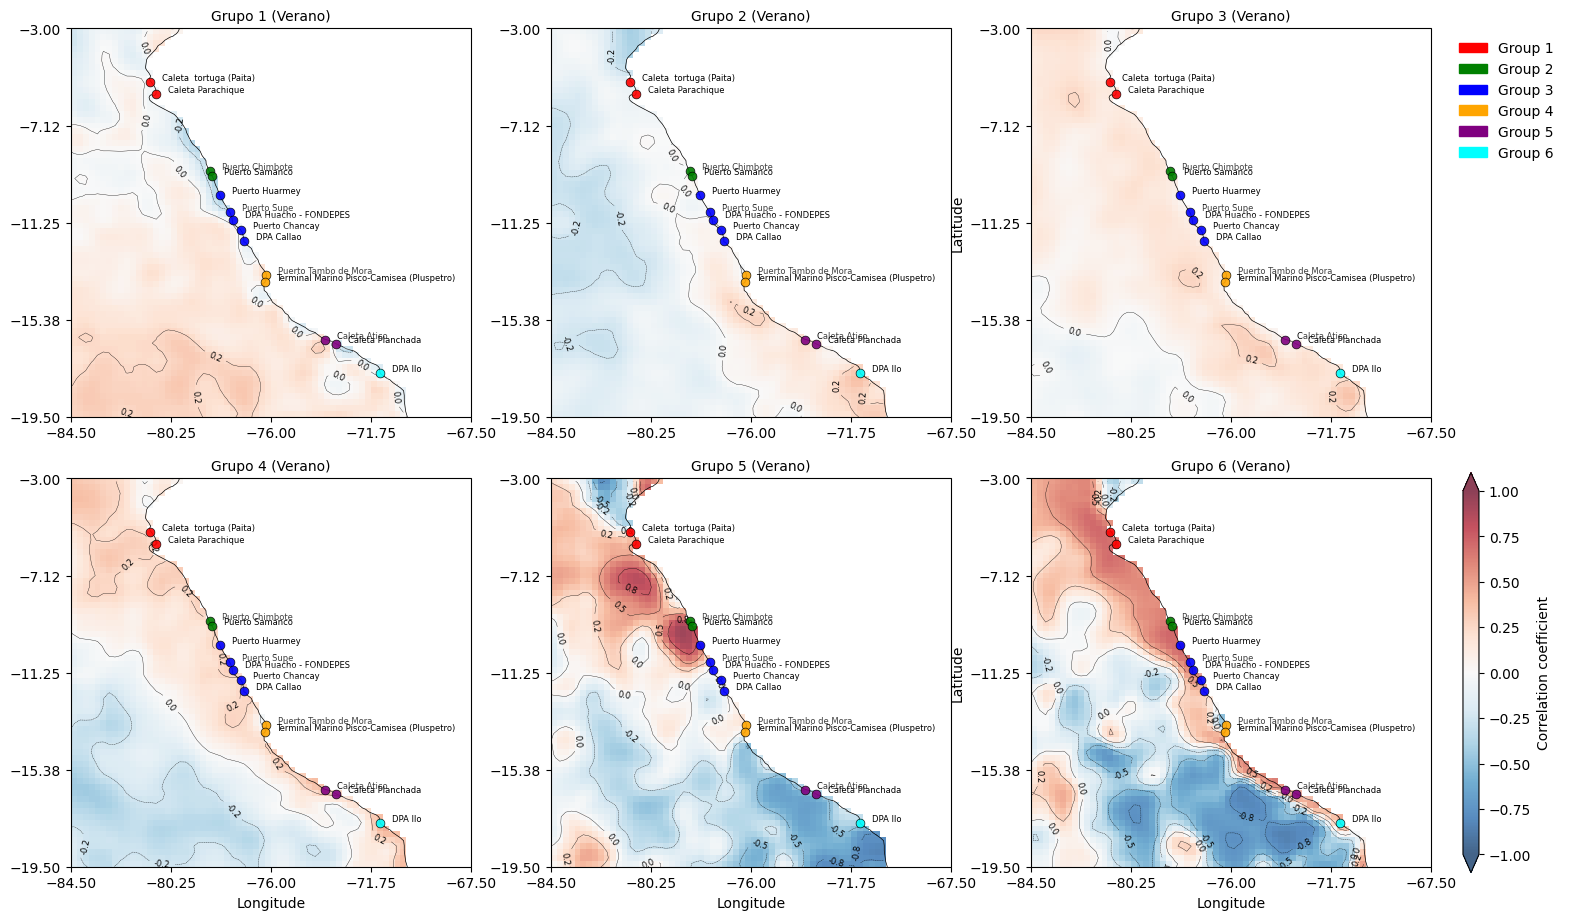

In [8]:

fig = plt.figure(figsize=(16,10))
axes_loc = [
    [0.70, 0.55, 0.25, 0.4],
    [0.40, 0.55, 0.25, 0.4],
    [0.10, 0.55, 0.25, 0.4],
    [0.70, 0.10, 0.25, 0.4],
    [0.40, 0.10, 0.25, 0.4],
    [0.10, 0.10, 0.25, 0.4]
]
axes = []
vars_plot = ['corr_sst_group3', 'corr_sst_group2', 'corr_sst_group1', 
             'corr_sst_group6', 'corr_sst_group5', 'corr_sst_group4']
title_vars_plot = ['Grupo 3', 'Grupo 2', 'Grupo 1', 
                   'Grupo 6', 'Grupo 5', 'Grupo 4']

for i, v in enumerate(vars_plot):
    ax_loc = axes_loc[i]
    data = ds_summary_oct_ene_smoothed[v]
    ax = plt.axes(ax_loc, projection=ccrs.PlateCarree())
    axes.append(ax)
    lon2d, lat2d = np.meshgrid(lon, lat)
    im = ax.pcolormesh(lon2d, lat2d, data.T, cmap='RdBu_r', vmin=-1, vmax=1,
                       transform=ccrs.PlateCarree(), alpha=0.75, shading='auto')
    levels = np.arange(np.floor(-1), np.ceil(1)+0.5, 0.25)
    contours = ax.contour(lon2d, lat2d, data.T, levels=levels, colors='k', linewidths=0.25,
                          transform=ccrs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=6, fmt="%.1f")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_title(f"{title_vars_plot[i]} (Verano)", fontsize=10)
    
    # Plot port locations by group
    for group, port_names in port_groups_full.items():
        df_group = df_ports[df_ports['caleta'].isin(port_names)]
        if not df_group.empty:
            ax.scatter(df_group['lon_decimal_corrected'], df_group['lat_decimal_corrected'],
                       color=group_colors[group], edgecolor='black', s=40, alpha=0.9, linewidths=0.5,
                       transform=ccrs.PlateCarree(), zorder=40)
            for _, row in df_group.iterrows():
                ax.text(row['lon_decimal_corrected']+0.5, row['lat_decimal_corrected'], row['caleta'],
                        fontsize=6, color='black', transform=ccrs.PlateCarree(),
                        ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))
    
    if i % 3 == 0:
        ax.set_ylabel('Latitude')
    if i >= 3:
        ax.set_xlabel('Longitude')

ax_cbar = plt.axes([0.97, 0.1, 0.01, 0.4])
cbar = fig.colorbar(im, cax=ax_cbar, orientation="vertical", extend='both')
cbar.set_label("Correlation coefficient")

import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=group_colors[group], label=group) for group in group_colors]
fig.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0.96, 0.8), frameon=False)

plt.show()


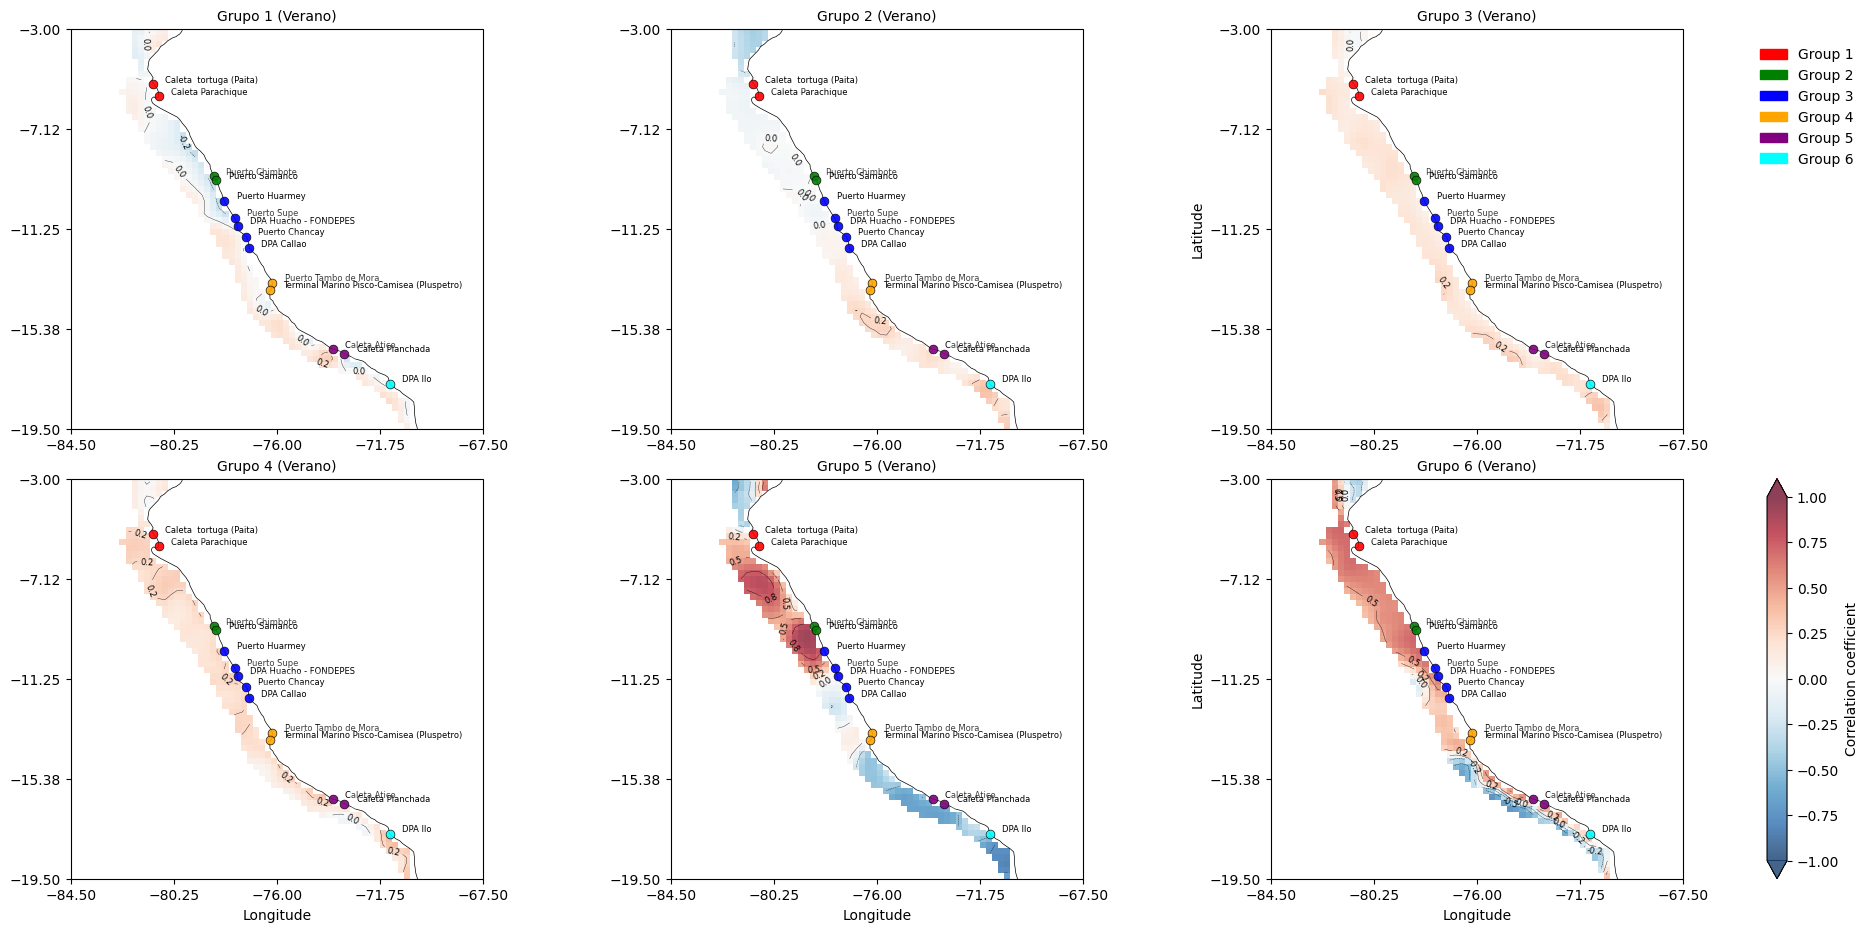

In [9]:

fig = plt.figure(figsize=(20,10))
axes_loc = [
    [0.70, 0.55, 0.25, 0.4],
    [0.40, 0.55, 0.25, 0.4],
    [0.10, 0.55, 0.25, 0.4],
    [0.70, 0.10, 0.25, 0.4],
    [0.40, 0.10, 0.25, 0.4],
    [0.10, 0.10, 0.25, 0.4]
]
axes = []
vars_plot = ['corr_sst_group3', 'corr_sst_group2', 'corr_sst_group1', 
             'corr_sst_group6', 'corr_sst_group5', 'corr_sst_group4']
title_vars_plot = ['Grupo 3', 'Grupo 2', 'Grupo 1', 
                   'Grupo 6', 'Grupo 5', 'Grupo 4']

for i, v in enumerate(vars_plot):
    ax_loc = axes_loc[i]
    data = ds_summary_oct_ene_smoothed[v]
    data = ds_summary_oct_ene_smoothed[v].where(~np.isnan(upwelling_mask_pesca_verano_da['upwelling_mask_pesca_verano']))

    ax = plt.axes(ax_loc, projection=ccrs.PlateCarree())
    axes.append(ax)
    lon2d, lat2d = np.meshgrid(lon, lat)
    im = ax.pcolormesh(lon2d, lat2d, data.T, cmap='RdBu_r', vmin=-1, vmax=1,
                       transform=ccrs.PlateCarree(), alpha=0.75, shading='auto')
    levels = np.arange(np.floor(-1), np.ceil(1)+0.5, 0.25)
    contours = ax.contour(lon2d, lat2d, data.values.T, levels=levels, colors='k', linewidths=0.25,
                          transform=ccrs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=6, fmt="%.1f")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.set_title(f"{title_vars_plot[i]} (Verano)", fontsize=10)
    
    # Plot port locations by group
    for group, port_names in port_groups_full.items():
        df_group = df_ports[df_ports['caleta'].isin(port_names)]
        if not df_group.empty:
            ax.scatter(df_group['lon_decimal_corrected'], df_group['lat_decimal_corrected'],
                       color=group_colors[group], edgecolor='black', s=40, alpha=0.9, linewidths=0.5,
                       transform=ccrs.PlateCarree(), zorder=40)
            for _, row in df_group.iterrows():
                ax.text(row['lon_decimal_corrected']+0.5, row['lat_decimal_corrected'], row['caleta'],
                        fontsize=6, color='black', transform=ccrs.PlateCarree(),
                        ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.25, edgecolor='none'))
    
    if i % 3 == 0:
        ax.set_ylabel('Latitude')
    if i >= 3:
        ax.set_xlabel('Longitude')

ax_cbar = plt.axes([0.97, 0.1, 0.01, 0.4])
cbar = fig.colorbar(im, cax=ax_cbar, orientation="vertical", extend='both')
cbar.set_label("Correlation coefficient")

import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=group_colors[group], label=group) for group in group_colors]
fig.legend(handles=legend_handles, loc='lower left', bbox_to_anchor=(0.96, 0.8), frameon=False)

plt.show()
